# SET UP

In [1]:
!pip install emoji

     |████████████████████████████████| 170 kB 7.6 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=e98ea04d0439d9fef28b1295fc2a38442d772cbe7f479fb6153f153e46308d8f
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [2]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 8.4 MB/s 
     |████████████████████████████████| 3.3 MB 33.2 MB/s 
     |████████████████████████████████| 596 kB 33.2 MB/s 
     |████████████████████████████████| 61 kB 462 kB/s 
     |████████████████████████████████| 895 kB 37.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install ekphrasis

     |████████████████████████████████| 80 kB 4.7 MB/s 
     |████████████████████████████████| 215 kB 23.7 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-py3-none-any.whl size=82842 sha256=6e431f874e388016bf764d6d4d924994cc11b15ba29423345944dcca05348f0a
  Stored in directory: /root/.cache/pip/wheels/f7/ec/0d/12659e32faf780546945d0120f2c8410eb3efb7426731da88f
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=e6075298d4fdd2a9b0811d0b241c780e88fd0a96fbba3087ecd33630dcc91f31
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ekphrasis ftfy


In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DL/Proj

Mounted at /content/drive
/content/drive/MyDrive/DL/Proj


In [81]:
import numpy as np
import pandas as pd
import emoji
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# PREPROCESS

## Text Preprocess

In [7]:
data_dir = 'data/'

In [8]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

In [9]:
emoticons_add = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

In [10]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter",
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter",
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, emoticons_add]
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [11]:
emo2label = {'happy': 0, 'sad': 1, 'angry': 2, 'others': 3}
label2meo = {0: 'happy', 1: 'sad', 2: 'angry', 3: 'others'}

In [12]:
train_data = pd.read_csv(data_dir+'train.txt', sep='\t').drop(columns='id')
test_data  = pd.read_csv(data_dir+'test.txt', sep='\t').drop(columns='id')
dev_data   = pd.read_csv(data_dir+'dev.txt', sep='\t').drop(columns='id')

In [13]:
def preprocess_emoji(text):
    
    text = text.lower().strip()
    text = emoji.demojize(text, delimiters=(' ', ' '))
    tokens = text.split()
    ret_list = []

    for token in tokens:
        if len(token) > 3 and '_' in token:
            token = token.replace('_', ' ')

        if token[0] == '<' and token[-1] == '>':
            token = token[1:-1]

        ret_list.append(token)

    return ' '.join(ret_list)
    

In [34]:
def preprocess_data(data_path):
    # read dataframe
    df = pd.read_csv(data_path, sep='\t').drop(columns='id')
    # preprocess emoji
    df.turn1 = df.turn1.apply(preprocess_emoji)
    df.turn2 = df.turn2.apply(preprocess_emoji)
    df.turn3 = df.turn3.apply(preprocess_emoji)
    # preprocess texts
    df.turn1 = df.turn1.apply(text_processor.pre_process_doc)
    df.turn2 = df.turn2.apply(text_processor.pre_process_doc)
    df.turn3 = df.turn3.apply(text_processor.pre_process_doc)
    
    df.label = df.label.apply(lambda x: emo2label[x])

    return df
    

In [57]:
train_data = preprocess_data(data_dir+'train.txt')
test_data  = preprocess_data(data_dir+'test.txt')
dev_data   = preprocess_data(data_dir+'dev.txt')

## Tokenization and BERT

In [16]:
from transformers import BertModel, BertTokenizer

model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)

bert_model = BertModel.from_pretrained(model_name)
bert_model.eval()
bert_model = bert_model.to(device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
def get_input_data(df):

    df.turn1 = df.turn1.apply(' '.join)
    df.turn2 = df.turn2.apply(' '.join)
    df.turn3 = df.turn3.apply(' '.join)

    df.turn1 = df.turn1.apply(lambda x: tokenizer(x, return_tensors='pt'))
    df.turn2 = df.turn2.apply(lambda x: tokenizer(x, return_tensors='pt'))
    df.turn3 = df.turn3.apply(lambda x: tokenizer(x, return_tensors='pt'))

    x = []
    with torch.no_grad():
        for i in tqdm(range(df.shape[0])):
            turn1 = df.loc[i, 'turn1'].to(device)
            turn1 = bert_model(**turn1)['last_hidden_state'] 
            turn1 = turn1[:, 0, :]
            turn2 = df.loc[i, 'turn2'].to(device)
            turn2 = bert_model(**turn2)['last_hidden_state']
            turn2 = turn2[:, 0, :]
            turn3 = df.loc[i, 'turn3'].to(device)
            turn3 = bert_model(**turn3)['last_hidden_state']
            turn3 = turn3[:, 0, :]

            x.append(torch.concat([turn1, turn2, turn3], dim=1))
    
    x = torch.concat(x, dim=0)
    y = torch.tensor(df.label).to(device)

    return x, y


In [59]:
train_x, train_y = get_input_data(train_data)
test_x, test_y = get_input_data(test_data)
dev_x, dev_y = get_input_data(dev_data)

  0%|          | 0/30160 [00:00<?, ?it/s]

  0%|          | 0/5509 [00:00<?, ?it/s]

  0%|          | 0/2755 [00:00<?, ?it/s]

# SETTINGS

## Define Loader

In [64]:
class EMODataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## Metric

In [66]:
def accuracy(y_pred, y):
    y_pred = torch.argmax(y_pred, dim=1)
    acc = torch.sum(y_pred == y) / y_pred.shape[0]
    return acc

In [67]:
def f1_score(conf):
    TP = torch.tensor([conf[i, i] for i in range(4)])
    FP = torch.sum(conf, 1) - TP
    FN = torch.sum(conf, 0) - TP
    P = TP / (TP + FP + 1e-5)
    R = TP / (TP + FN + 1e-5)
    F1 = torch.mean(2 / (1/P+1/R))
    return P, R, F1

In [68]:
def confusion_add(conf, y_pred, y):
    y_pred = torch.argmax(y_pred, dim=1)
    for i in range(len(y)):
        conf[y_pred[i], y[i]] += 1

In [69]:
def criterion(y_pred, y):
    return F.cross_entropy(y_pred, y)

## Train and Evaluate

In [70]:
def train(model, loader, optimizer, scheduler, criterion):

    model.train()

    epoch_loss = []
    epoch_acc  = []
    conf = torch.zeros(4, 4)

    for x, y in loader:
        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = accuracy(y_pred, y)
        confusion_add(conf, y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += [loss.item()]
        epoch_acc  += [acc.item()]
    
    scheduler.step()

    return np.mean(epoch_loss), np.mean(epoch_acc), conf


In [71]:
def evaluate(model, loader, criterion):

    model.eval()

    epoch_loss = []
    epoch_acc  = []
    conf = torch.zeros(4, 4)

    with torch.no_grad():
        for x, y in loader:
            y = y.to(device)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            acc  = accuracy(y_pred, y)
            confusion_add(conf, y_pred, y)

            epoch_loss += [loss.item()]
            epoch_acc  += [acc.item()]

    return np.mean(epoch_loss), np.mean(epoch_acc), conf

# MLP

## Model

In [72]:
class EMOMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout):

        super().__init__()

        self.decode = nn.Sequential(
            nn.Linear(3*input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )


    def forward(self, x):

        x = self.decode(x)

        return x


## Experiment

In [79]:
BATCH_SIZE = 20

train_loader = DataLoader(EMODataset(train_x, train_y),
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader  = DataLoader(EMODataset(test_x, test_y),
                          batch_size=BATCH_SIZE,
                          shuffle=True)
dev_loader   = DataLoader(EMODataset(dev_x, dev_y),
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [90]:
model_path = 'models/EMOMLP.pth'

model = EMOMLP(768, 4, 128, 0.3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [91]:
N_EPOCH = 20

train_loss_list, dev_loss_list = [], []
min_f1 = 0

for epoch in range(N_EPOCH):
    train_loss, train_acc, train_conf = train(model, train_loader, optimizer, scheduler, criterion)
    dev_loss, dev_acc, dev_conf = evaluate(model, dev_loader, criterion)

    train_loss_list.append(train_loss)
    dev_loss_list.append(dev_loss)

    dev_P, dev_R, dev_f1 = f1_score(dev_conf)

    if dev_f1 > min_f1:
        torch.save(model.state_dict(), model_path)
        min_f1 = dev_f1

    print('[epoch %02d] train loss: %2.2f, dev loss: %2.2f, dev accuracy: %2.2f%%, dev f1 score: %2.2f%%' %
          (epoch+1, train_loss, dev_loss, dev_acc*100, dev_f1*100))
    print('P: %.2f %.2f %.2f %.2f | R: %.2f %.2f %.2f %.2f' %
          (dev_P[0], dev_P[1], dev_P[2], dev_P[3], dev_R[0], dev_R[1], dev_R[2], dev_R[3]))

Adjusting learning rate of group 0 to 8.0000e-04.
[epoch 01] train loss: 0.70, dev loss: 0.50, dev accuracy: 83.47%, dev f1 score: 64.63%
P: 0.41 0.74 0.38 0.96 | R: 0.70 0.56 0.85 0.86
Adjusting learning rate of group 0 to 6.4000e-04.
[epoch 02] train loss: 0.60, dev loss: 0.39, dev accuracy: 86.11%, dev f1 score: 65.97%
P: 0.48 0.44 0.59 0.96 | R: 0.68 0.78 0.59 0.89
Adjusting learning rate of group 0 to 5.1200e-04.
[epoch 03] train loss: 0.56, dev loss: 0.46, dev accuracy: 83.02%, dev f1 score: 65.81%
P: 0.33 0.66 0.49 0.97 | R: 0.86 0.68 0.72 0.84
Adjusting learning rate of group 0 to 4.0960e-04.
[epoch 04] train loss: 0.53, dev loss: 0.48, dev accuracy: 83.97%, dev f1 score: 66.32%
P: 0.46 0.52 0.43 0.97 | R: 0.76 0.75 0.82 0.85
Adjusting learning rate of group 0 to 3.2768e-04.
[epoch 05] train loss: 0.51, dev loss: 0.36, dev accuracy: 87.20%, dev f1 score: 68.63%
P: 0.59 0.54 0.51 0.96 | R: 0.55 0.78 0.79 0.90
Adjusting learning rate of group 0 to 2.6214e-04.
[epoch 06] train los

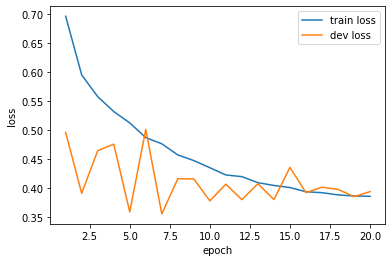

In [92]:
plt.figure()
plt.plot(np.arange(1, N_EPOCH+1), train_loss_list, label='train loss')
plt.plot(np.arange(1, N_EPOCH+1), dev_loss_list, label='dev loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [94]:
model = EMOMLP(768, 4, 128, 0.3)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

test_loss, test_acc, test_conf = evaluate(model, test_loader, criterion)

test_P, test_R, test_f1 = f1_score(test_conf)

print('test loss: %2.2f, test accuracy: %2.2f%%, test f1 score: %2.2f%%' %
      (test_loss, test_acc*100, test_f1*100))
print('P: %.2f %.2f %.2f %.2f | R: %.2f %.2f %.2f %.2f' %
      (test_P[0], test_P[1], test_P[2], test_P[3], test_R[0], test_R[1], test_R[2], test_R[3]))

test loss: 0.37, test accuracy: 86.91%, test f1 score: 69.82%
P: 0.58 0.54 0.48 0.96 | R: 0.69 0.78 0.79 0.89
